## Human-in-the-Loop ML Final Project -

### Gathering datasets from Reddit

In [ ]:
!pip install asyncpraw
!pip install nest_asyncio
!pip install playwright
!playwright install

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 MB 24.1 MB/s eta 0:00:00
161.3 MiB [] 0% 0.0s161.3 MiB [] 0% 3.8s161.3 MiB [] 1% 2.6s161.3 MiB [] 1% 2.7s161.3 MiB [] 2% 2.4s161.3 MiB [] 3% 3.0s161.3 MiB [] 3% 3.3s161.3 MiB [] 3% 3.4s161.3 MiB [] 4% 2.9s161.3 MiB [] 5% 2.7s161.3 MiB [] 6% 2.5s161.3 MiB [] 6% 2.6s161.3 MiB [] 7% 2.5s161.3 MiB [] 8% 2.3s161.3 MiB [] 9% 2.2s161.3 MiB [] 10% 2.1s161.3 MiB [] 11% 2.0s161.3 MiB [] 12% 2.0s161.3 MiB [] 13% 1.9s161.3 MiB [] 14% 1.9s161.3 MiB [] 15% 1.8s161.3 MiB [] 17% 1.7s161.3 MiB [] 19% 1.6s161.3 MiB [] 20% 1.6s161.3 MiB [] 21% 1.5s161.3 MiB [] 22% 1.5s161.3 MiB [] 23% 1.5s161.3 MiB [] 24% 1.4s161.3 MiB [] 25% 1.4s161.3 MiB [] 26% 1.4s161.3 MiB [] 27% 1.4s161.3 MiB [] 28% 1.3s161.3 MiB [] 29% 1.3s161.3 MiB [] 29% 1.4s161.3 MiB [] 30% 1.3s161.3 MiB [] 31% 1.3s161.3 MiB [] 32% 1.2s161.3 MiB [] 34% 1.2s161.3 MiB [] 35% 1.2s161.3 MiB [] 36% 1.2s161.3 MiB [] 38

In [1]:
# import asyncio
# import nest_asyncio
# import asyncpraw
# from playwright.async_api import async_playwright
import pandas as pd
from datetime import datetime

#### Collecting comments from r/politics based on 5 controversial topics

In [ ]:
nest_asyncio.apply()

async def scrape_comments():
    user_agent = "praw_SA"

    # Authenticate with Reddit API
    reddit = asyncpraw.Reddit(
        client_id="nCEd6ndMG0EBU6lMOS1csQ",
        client_secret="cF98zVtfxef_DIEyt1jn9-zBTujetg",
        user_agent=user_agent
    )

    # Parameters
    subreddit_name = "politics"
    comments_per_query = 2500  # Set to collect 2000 comments per query
    sort_by = "hot"
    comments_data = []

    subreddit = await reddit.subreddit(subreddit_name)
    search_queries = ['trump', 'biden', 'kamala', 'guns', 'ukraine', 'israel']

    for search_query in search_queries:
        try:
            comments_collected_for_query = 0  # Reset counter for each query
            print(f"\nStarting collection for query: {search_query}")

            async for submission in subreddit.search(query=search_query, sort=sort_by, limit=None):
                try:
                    # Fetch the full submission to ensure comments are loaded
                    full_submission = await reddit.submission(id=submission.id)
                    if not full_submission.comments:
                        continue

                    # Load all comments
                    try:
                        await full_submission.comments.replace_more(limit=None)
                        comment_queue = full_submission.comments.list()

                        for comment in comment_queue:
                            if isinstance(comment, asyncpraw.models.Comment):
                                ups = comment.ups
                                downs = abs(comment.downs)
                                total_votes = ups + downs if (ups + downs) > 0 else 1

                                comments_data.append({
                                    "comment_id": comment.id,
                                    "submission_id": submission.id,
                                    "author": str(comment.author),
                                    "created_utc": datetime.utcfromtimestamp(comment.created_utc).isoformat(),
                                    "body": comment.body,
                                    "upvote_ratio": ups / total_votes,
                                    "downvote_ratio": downs / total_votes,
                                    "score": comment.score,
                                    "ups": ups,
                                    "downs": downs,
                                    "search_query": search_query
                                })

                                comments_collected_for_query += 1

                                # Print progress every 500 comments and show the comment
                                if comments_collected_for_query % 500 == 0:
                                    print(f"\nCollected {comments_collected_for_query} comments for '{search_query}'")
                                    print(f"Sample comment: {comment.body[:200]}...")  # Print first 200 chars of comment

                                if comments_collected_for_query >= comments_per_query:
                                    break

                    except Exception as e:
                        print(f"Error processing comments for submission {submission.id}: {str(e)}")
                        continue

                except Exception as e:
                    print(f"Error processing submission: {str(e)}")
                    continue

                if comments_collected_for_query >= comments_per_query:
                    print(f"\nCompleted collection for '{search_query}' with {comments_collected_for_query} comments")
                    break

        except Exception as e:
            print(f"Error in search query '{search_query}': {str(e)}")
            continue

    # Save data to a CSV file
    df = pd.DataFrame(comments_data)
    df.to_csv("subreddit_comments.csv", index=False)
    print(f"\nTotal comments scraped: {len(comments_data)}")
    print(f"Comments saved to subreddit_comments.csv")

    # Print summary of comments collected per query
    summary = df['search_query'].value_counts()
    print("\nComments collected per query:")
    print(summary)

# Run the async function
asyncio.run(scrape_comments())


Starting collection for query: trump

Collected 500 comments for 'trump'
Sample comment: Harris ran an epically bad campaign compounded by Biden's hubris to let him off the hook....

Collected 1000 comments for 'trump'
Sample comment: It's even significantly worse than that. Guy who recorded that,  Georgia's Secretary of State Brad F, seems to be on team Trump now because he tried to cover up... I mean he did successfully cover up....

Collected 1500 comments for 'trump'
Sample comment: After covid I'm not surprised by the average person anymore. It really showed true human nature, especially in this country....

Collected 2000 comments for 'trump'
Sample comment: The great freeze was just the Democrats using their weather machine to punish righteous, God-fearing Texans!...

Collected 2500 comments for 'trump'
Sample comment: You’re saying doing those things are good ? That’s disgusting...

Completed collection for 'trump' with 2500 comments

Starting collection for query: biden

Coll

ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7db914e26530>



Collected 1000 comments for 'kamala'
Sample comment: I feel like this is a self report on the campaign.  Real "how do you do fellow kids?" energy....

Collected 1500 comments for 'kamala'
Sample comment: You remind me of the introduction scene of the TV show "Newsroom"

> Fine. Sharon, the NEA is a loser. Yeah, it accounts for a penny out of our paycheck, but he gets to hit you with it any time he wan...

Collected 2000 comments for 'kamala'
Sample comment: LMAO this is hilarious. CNN can suck it for sanewashing trump throughout the election. Reap what you sow...
Error processing comments for submission 1gtgx3m: received 429 HTTP response

Collected 2500 comments for 'kamala'
Sample comment: Hillary won the popular vote....

Completed collection for 'kamala' with 2500 comments

Starting collection for query: guns

Collected 500 comments for 'guns'
Sample comment: What? Women have always skewed Democratic/liberal. In this past election the gender gap was 10%. 

Also, gender gap in gun 

### Collecting comments from r/politics that have been banned by moderators (assumed to be human experts)

In [ ]:
async def scrape_reveddit_playwright():
    async with async_playwright() as p:
        browser = await p.chromium.launch(
            headless=True,
            args=['--disable-dev-shm-usage']
        )
        context = await browser.new_context(
            user_agent='Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36'
        )
        page = await context.new_page()

        try:
            print("Loading Reveddit page...")
            await page.goto("https://www.reveddit.com/v/politics/history/?showFilters=true&n=1000",
                          wait_until="networkidle")

            # Handle initial popup
            try:
                modal = await page.wait_for_selector('#genericModal', timeout=5000)
                if modal:
                    dismiss_button = await page.query_selector('#genericModal .dismiss a')
                    if dismiss_button:
                        await dismiss_button.click()
                        print("Initial popup dismissed")
            except Exception as e:
                print("No initial popup found or already dismissed")

            # Wait for content
            print("Waiting for comments to load...")
            await page.wait_for_selector('.comment-body', timeout=60000)

            # Small delay to ensure everything is loaded
            await asyncio.sleep(5)

            # Get all comments
            comments = await page.query_selector_all('.comment-body')
            comment_data = []

            print(f"Found {len(comments)} comments. Extracting data...")

            for comment in comments:
                try:
                    # Get the parent element that contains all the metadata
                    parent_element = await comment.evaluate('element => element.closest(".comment")')

                    # Extract comment text (handling both normal and orphaned comments)
                    text = await comment.evaluate('''
                        element => {
                            const textDiv = element.querySelector('div > p');
                            return textDiv ? textDiv.innerText : '';
                        }
                    ''')

                    # Check if comment is orphaned
                    orphaned_notice = await comment.query_selector('.notice-with-link.orphaned')
                    is_orphaned = True if orphaned_notice else False

                    # Get metadata from parent element
                    metadata = await page.evaluate('''
                        parentId => {
                            const parent = document.querySelector(`[data-fullname="${parentId}"]`);
                            if (!parent) return {};

                            return {
                                author: parent.querySelector('.author')?.innerText || 'Unknown',
                                score: parent.querySelector('.score')?.innerText || '0',
                                timestamp: parent.querySelector('.timestamp')?.innerText || 'Unknown',
                                removal_status: parent.querySelector('.removal-reason')?.innerText || 'Not removed'
                            };
                        }
                    ''', parent_element)

                    data = {
                        'text': text,
                        'is_orphaned': is_orphaned,
                        'author': metadata.get('author', 'Unknown'),
                        'score': metadata.get('score', '0'),
                        'timestamp': metadata.get('timestamp', 'Unknown'),
                        'removal_status': metadata.get('removal_status', 'Not removed')
                    }

                    comment_data.append(data)
                    print(f"Extracted comment by {data['author']}")

                except Exception as e:
                    print(f"Error extracting comment: {str(e)}")
                    continue

            # Save to CSV
            if comment_data:
                df = pd.DataFrame(comment_data)
                filename = f"reddit_removed_comments.csv"
                df.to_csv(filename, index=False, encoding='utf-8')
                print(f"\nSaved {len(df)} comments to {filename}")

                # Display sample
                print("\nSample of collected data:")
                print(df.head())
            else:
                print("No comments found")

        except Exception as e:
            print(f"An error occurred: {str(e)}")
            await page.screenshot(path="error_screenshot.png")
            print("Error screenshot saved as 'error_screenshot.png'")

        finally:
            await browser.close()

# Run the scraper
def run_scraper():
    try:
        asyncio.get_event_loop().run_until_complete(scrape_reveddit_playwright())
    except RuntimeError:
        asyncio.run(scrape_reveddit_playwright())

if __name__ == "__main__":
    run_scraper()

Loading Reveddit page...
Initial popup dismissed
Waiting for comments to load...
Found 974 comments. Extracting data...
Extracted comment by Unknown


ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7db90e12bb80>


Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comment by Unknown
Extracted comm

In [ ]:
!cp /content/subreddit_comments.csv /content/drive/MyDrive/Datasets
!cp /content/reddit_mod_removed_comments.csv /content/drive/MyDrive/Datasets

### Preprocessing Datasets

In [10]:
subreddit_comments = pd.read_csv('/content/drive/MyDrive/Datasets/subreddit_comments.csv')
mod_removed_comments = pd.read_csv('/content/drive/MyDrive/Datasets/reddit_mod_removed_comments.csv')

In [8]:
import tensorflow as tf
from keras.layers import TextVectorization

def preprocess_dataset(X, Y, max_features=20000, output_sequence_length=1800, batch_size=16):
  """
  Preprocess the dataset for text classification.

  Parameters:
  - X: Input text data (e.g., a pandas Series or numpy array).
  - Y: Corresponding labels (e.g., a pandas Series or numpy array).
  - max_features: Maximum number of unique tokens to consider.
  - output_sequence_length: Length of the output sequences.
  - batch_size: Size of the batches for training.

  Returns:
  - train: Training dataset.
  - val: Validation dataset.
  - test: Test dataset.
  """
  vectorizer = TextVectorization(max_tokens=max_features, output_sequence_length=output_sequence_length, output_mode='int')
  vectorizer.adapt(X.values)
  vectorized_text = vectorizer(X.values)
  dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, Y))
  dataset = dataset.cache()
  dataset = dataset.shuffle(buffer_size=len(X))
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(tf.data.AUTOTUNE)
  train_size = int(len(dataset) * 0.7)
  val_size = int(len(dataset) * 0.2)

  train = dataset.take(train_size)
  val = dataset.skip(train_size).take(val_size)
  test = dataset.skip(train_size + val_size)

  return train, val, test

#### Preprocessing Kaggle dataset for establishing a baseline for explicit toxicity detection.

In [ ]:
!kaggle competitions download -c jigsaw-toxic-comment-classification-challenge
!unzip /content/jigsaw-toxic-comment-classification-challenge.zip -d /content/dataset_files
!unzip /content/dataset_files/train.csv.zip -d /content/dataset_files
!unzip /content/dataset_files/test.csv.zip -d /content/dataset_files
!rm /content/dataset_files/test.csv.zip
!rm /content/dataset_files/train.csv.zip

 95% 50.0M/52.6M [00:01<00:00, 37.7MB/s]
100% 52.6M/52.6M [00:01<00:00, 28.2MB/s]
Archive:  /content/jigsaw-toxic-comment-classification-challenge.zip
  inflating: /content/dataset_files/sample_submission.csv.zip  
  inflating: /content/dataset_files/test.csv.zip  
  inflating: /content/dataset_files/test_labels.csv.zip  
  inflating: /content/dataset_files/train.csv.zip  
Archive:  /content/dataset_files/train.csv.zip
  inflating: /content/dataset_files/train.csv  
Archive:  /content/dataset_files/test.csv.zip
  inflating: /content/dataset_files/test.csv  


In [ ]:
df = pd.read_csv('/content/dataset_files/train.csv')
X = df['comment_text']
Y = df['toxic']

In [ ]:
train, val, test = preprocess_dataset(X, Y)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

MAX_FEATURES = 20000

In [ ]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM Layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
class BatchHistoryCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(BatchHistoryCallback, self).__init__()
        self.batch_losses = []
        self.batch_val_losses = []

    def on_train_batch_end(self, batch, logs=None):
        self.batch_losses.append(logs.get('loss'))

    def on_test_batch_end(self, batch, logs=None):
        self.batch_val_losses.append(logs.get('loss'))

# Create the callback
batch_history = BatchHistoryCallback()

In [ ]:
history = model.fit(train, epochs=5, validation_data=val, callbacks=[batch_history])

Epoch 1/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 756s 107ms/step - loss: 0.1697 - val_loss: 0.0892
Epoch 2/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 733s 105ms/step - loss: 0.1003 - val_loss: 0.0849
Epoch 3/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 741s 106ms/step - loss: 0.0854 - val_loss: 0.0729
Epoch 4/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 738s 106ms/step - loss: 0.0717 - val_loss: 0.0615
Epoch 5/5
6981/6981 ━━━━━━━━━━━━━━━━━━━━ 728s 104ms/step - loss: 0.0652 - val_loss: 0.0529


In [ ]:
batch_losses = batch_history.batch_losses  # Training batch losses
batch_val_losses = batch_history.batch_val_losses  # Validation batch losses

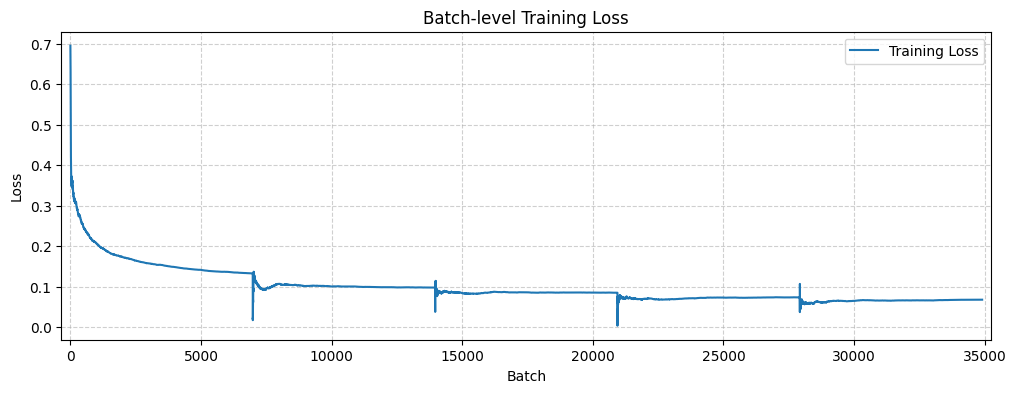

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.plot(batch_losses, label='Training Loss')
# plt.plot(batch_val_losses, label='Validation Loss', alpha=0.7)

plt.title('Batch-level Training Loss')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
# plt.yscale('log')  # Use log scale if losses vary widely
plt.margins(x=0.01)  # Reduce horizontal margins
plt.savefig('loss_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
model.save('pretrained_lstm.keras')

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/pretrained_lstm.keras')

In [ ]:
ft_comments_df = subreddit_comments[['body', 'upvote_ratio']].copy()
ft_comments_df['upvote_ratio'] = (ft_comments_df['upvote_ratio'] < 0.5).astype(int)
ft_comments_df = ft_comments_df.rename(columns={'upvote_ratio': 'toxic'})

print("Distribution of labels:")
print(ft_comments_df['toxic'].value_counts())

Distribution of labels:
toxic
0    12051
1     2949
Name: count, dtype: int64


In [13]:
mod_removed_comments_df = pd.DataFrame({
    'body': mod_removed_comments['text'],  # Use the text column as body
    'toxic': 1
})

mod_removed_comments_df.head()

,body,toxic
0,"Frankly, this is the most justified police sho...",1
1,"""Nothing will fundamentally change"" is a campa...",1
2,"This is a meta problem that liberals, leftists...",1
3,"> > ""I prefer to go to funerals for people who...",1
4,Pro-Impeachment protests scheduled all over th...,1


### Checking baseline performance of the pretrained model on the scraped subreddit dataset

In [ ]:
def evaluate_model(model, comments_df):
    X = comments_df['body']
    Y = comments_df['toxic']
    test_data, _, _ = preprocess_dataset(X, Y, batch_size=32)

    results = model.evaluate(test_data)
    return results

In [ ]:
def evaluate_model(model, comments_df):
    """
    Evaluate model on the given dataset

    Args:
        model: Trained model to evaluate
        comments_df: DataFrame with 'body' and 'toxic' columns

    Returns:
        Evaluation results
    """
    # Ensure model is compiled
    if not model.compiled_loss:
        model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )

    # Preprocess the data using the same function from the document
    X = comments_df['body']
    Y = comments_df['toxic']
    test_data, _, _ = preprocess_dataset(X, Y,
                                       max_features=20000,  # Same as MAX_FEATURES in document
                                       output_sequence_length=1800,
                                       batch_size=32)

    # Evaluate
    results = model.evaluate(test_data, verbose=1)

    # Print results in a readable format
    print("\nEvaluation Results:")
    print(f"Loss: {results[0]:.4f}")
    print(f"Accuracy: {results[1]:.4f}")

    return results

# Example usage:
# evaluation_results = evaluate_model(model, comments_df)

In [ ]:
from tensorflow.keras.models import clone_model
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

baseline_model = model  # Original pretrained model
bc_model = clone_model(model)  # Copy for behavior cloning
dpo_model = clone_model(model)

In [ ]:
baseline_model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
evaluation_results = evaluate_model(model, mod_removed_comments_df)
print("Baseline Evaluation Results:")
print(f"Loss: {evaluation_results[0]}, Accuracy: {evaluation_results[1]}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.0810 - loss: 6.1577
Baseline Evaluation Results:
Loss: 6.03141975402832, Accuracy: 0.0877976194024086


### Applying Behavior Cloning

In [ ]:
def train_behavior_cloning(model, comments_df):
    X = comments_df['body']
    Y = comments_df['toxic']

    train_data, val_data, test_data = preprocess_dataset(X, Y, batch_size=32)
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        train_data,
        validation_data=val_data,
        epochs=5,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=2,
                restore_best_weights=True
            )
        ]
    )
    return model, history

In [ ]:
bc_model, history = train_behavior_cloning(bc_model, ft_comments_df)

Epoch 1/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 36s 104ms/step - accuracy: 0.7975 - loss: 0.5241 - val_accuracy: 0.7967 - val_loss: 0.4577
Epoch 2/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.8097 - loss: 0.4346 - val_accuracy: 0.8642 - val_loss: 0.3360
Epoch 3/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 41s 103ms/step - accuracy: 0.8632 - loss: 0.3337 - val_accuracy: 0.9089 - val_loss: 0.2365
Epoch 4/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 41s 104ms/step - accuracy: 0.9065 - loss: 0.2415 - val_accuracy: 0.9385 - val_loss: 0.1689
Epoch 5/5
328/328 ━━━━━━━━━━━━━━━━━━━━ 36s 109ms/step - accuracy: 0.9340 - loss: 0.1774 - val_accuracy: 0.9590 - val_loss: 0.1145


In [ ]:
evaluation_results = evaluate_model(bc_model, mod_removed_comments_df)
print("Behavior Cloning Evaluation Results:")
print(f"Loss: {evaluation_results[0]}, Accuracy: {evaluation_results[1]}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.1434 - loss: 2.8245
Behavior Cloning Evaluation Results:
Loss: 2.7988595962524414, Accuracy: 0.1428571492433548


### Applying DPO

#### Creating preference pairs for DPO

In [ ]:
# First create a copy of the original dataframe with the columns we need
ft_comments_df = subreddit_comments[['body', 'upvote_ratio']].copy()

def create_dpo_pairs(df, min_ratio_diff=0.1, max_pairs=None):
    """
    Create preference pairs for DPO training with a minimum difference in upvote ratios.

    Args:
        df: DataFrame with 'body' and 'upvote_ratio' columns
        min_ratio_diff: Minimum difference in upvote ratios to consider a preference
        max_pairs: Maximum number of pairs to generate (optional)
    """

    df = df.sort_values('upvote_ratio', ascending=False)
    pairs = []
    used_indices = set()

    for i in range(len(df)):
        if i in used_indices:
            continue
        preferred_row = df.iloc[i]
        potential_non_preferred = df[
            (df['upvote_ratio'] < preferred_row['upvote_ratio'] - min_ratio_diff) &
            (df.index > i)
        ]

        if len(potential_non_preferred) > 0:
            non_preferred_row = potential_non_preferred.iloc[0]

            pairs.append({
                'preferred_text': preferred_row['body'],
                'preferred_score': preferred_row['upvote_ratio'],
                'non_preferred_text': non_preferred_row['body'],
                'non_preferred_score': non_preferred_row['upvote_ratio'],
                'preference_gap': preferred_row['upvote_ratio'] - non_preferred_row['upvote_ratio']
            })

            used_indices.add(i)
            used_indices.add(potential_non_preferred.index[0])

            if max_pairs and len(pairs) >= max_pairs:
                break

    return pd.DataFrame(pairs)

dpo_dataset = create_dpo_pairs(ft_comments_df, min_ratio_diff=0.2)

print("DPO Dataset Statistics:")
print(f"Number of preference pairs: {len(dpo_dataset)}")
print("\nAverage preference gap:", dpo_dataset['preference_gap'].mean())

if len(dpo_dataset) > 0:
    print("\nSample preference pair:")
    sample = dpo_dataset.iloc[0]
    print("\nPreferred text (score: {:.2f}):".format(sample['preferred_score']))
    print(sample['preferred_text'][:200] + "..." if len(sample['preferred_text']) > 200 else sample['preferred_text'])
    print("\nNon-preferred text (score: {:.2f}):".format(sample['non_preferred_score']))
    print(sample['non_preferred_text'][:200] + "..." if len(sample['non_preferred_text']) > 200 else sample['non_preferred_text'])

dpo_dataset.to_csv('dpo_pairs.csv', index=False)

In [ ]:
def train_dpo(model, dpo_dataset, max_features=20000, output_sequence_length=1800, batch_size=32):
    """
    Train model using Direct Preference Optimization

    Args:
        model: The model to train
        dpo_dataset: DataFrame with preference pairs
        max_features: Maximum number of unique tokens to consider
        output_sequence_length: Length of the output sequences
        batch_size: Training batch size
    """
    # Prepare the inputs
    preferred_texts = dpo_dataset['preferred_text'].values
    non_preferred_texts = dpo_dataset['non_preferred_text'].values
    preference_gaps = dpo_dataset['preference_gap'].values

    # Create TextVectorization layer
    vectorizer = TextVectorization(
        max_tokens=max_features,
        output_sequence_length=output_sequence_length,
        output_mode='int'
    )
    vectorizer.adapt(preferred_texts)

    # Vectorize texts
    vectorized_preferred = vectorizer(preferred_texts)
    vectorized_non_preferred = vectorizer(non_preferred_texts)

    # Create dataset
    dataset = tf.data.Dataset.from_tensor_slices((
        (vectorized_preferred, vectorized_non_preferred),
        preference_gaps
    ))

    # Apply standard preprocessing
    dataset = dataset.cache()
    dataset = dataset.shuffle(buffer_size=len(dpo_dataset))
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    # Split dataset
    train_size = int(len(dataset) * 0.7)
    val_size = int(len(dataset) * 0.2)

    train = dataset.take(train_size)
    val = dataset.skip(train_size).take(val_size)

    # Compile the model
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # Train the model
    history = model.fit(
        train,
        validation_data=val,
        epochs=5,
        callbacks=[
            tf.keras.callbacks.EarlyStopping(
                monitor='val_loss',
                patience=2,
                restore_best_weights=True
            )
        ]
    )

    return model, history

In [ ]:
dpo_model, dpo_history = train_dpo(dpo_model, dpo_dataset)

Epoch 1/5
325/325 ━━━━━━━━━━━━━━━━━━━━ 38s 110ms/step - accuracy: 0.9900 - loss: -85.8523 - val_accuracy: 0.9943 - val_loss: -1609.9406
Epoch 2/5
325/325 ━━━━━━━━━━━━━━━━━━━━ 42s 114ms/step - accuracy: 0.9919 - loss: -7311.8325 - val_accuracy: 0.9933 - val_loss: -34961.6523
Epoch 3/5
325/325 ━━━━━━━━━━━━━━━━━━━━ 39s 108ms/step - accuracy: 0.9913 - loss: -79215.2656 - val_accuracy: 0.9923 - val_loss: -223034.0938
Epoch 4/5
325/325 ━━━━━━━━━━━━━━━━━━━━ 40s 104ms/step - accuracy: 0.9910 - loss: -394143.7188 - val_accuracy: 0.9913 - val_loss: -879193.4375
Epoch 5/5
325/325 ━━━━━━━━━━━━━━━━━━━━ 41s 105ms/step - accuracy: 0.9928 - loss: -889880.0625 - val_accuracy: 0.9906 - val_loss: -1923515.5000


In [ ]:
evaluation_results = evaluate_model(dpo_model, mod_removed_comments_df)
print("Direct Preference Optimization Evaluation Results:")
print(f"Loss: {evaluation_results[0]}, Accuracy: {evaluation_results[1]}")

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 1.0000 - loss: 0.0000e+00
Direct Preference Optimization Evaluation Results:
Loss: 0.0, Accuracy: 1.0


In [ ]:
bc_model.save('/content/drive/MyDrive/Datasets/behavior_cloning_lstm.keras')
dpo_model.save('/content/drive/MyDrive/Datasets/direct_preference_optimization_lstm.keras')

In [ ]:
history_df = pd.DataFrame(history.history)
history_df.to_csv('/content/drive/MyDrive/Datasets/behavior_cloning_history.csv', index=False)

In [ ]:
dpo_history_df = pd.DataFrame(dpo_history.history)
dpo_history_df.to_csv('/content/drive/MyDrive/Datasets/dpo_history.csv', index=False)

### Visualizing results

In [3]:
bc_history_df = pd.read_csv('/content/drive/MyDrive/Datasets/behavior_cloning_history.csv')
dpo_history_df = pd.read_csv('/content/drive/MyDrive/Datasets/dpo_history.csv')

In [9]:
bc_model = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/behavior_cloning_lstm.keras')
dpo_model = tf.keras.models.load_model('/content/drive/MyDrive/Datasets/direct_preference_optimization_lstm.keras')

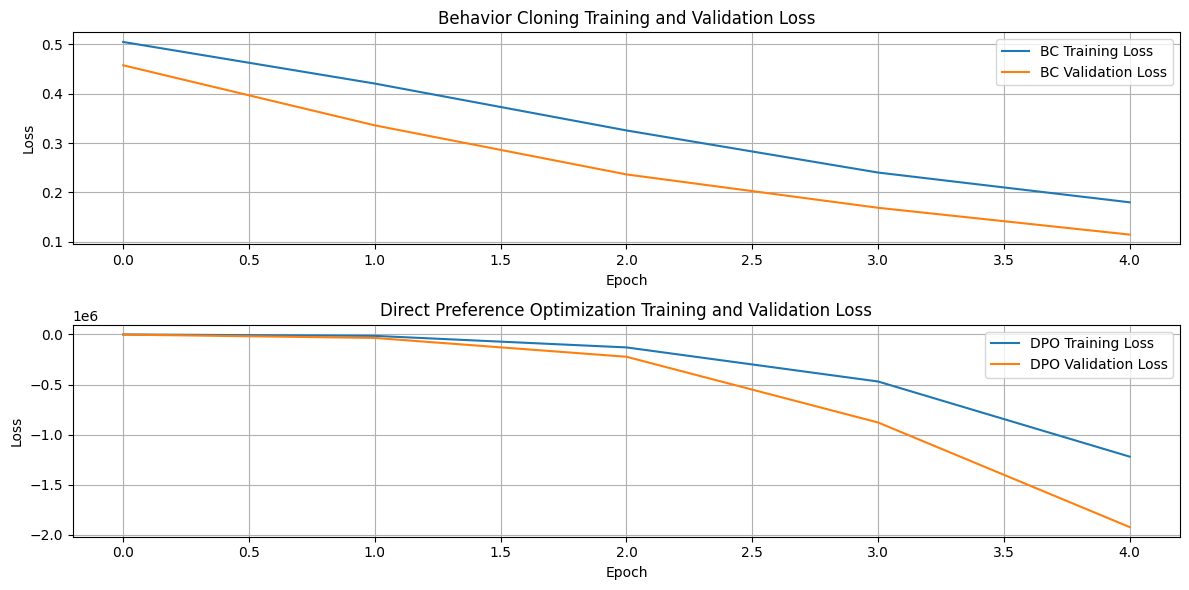

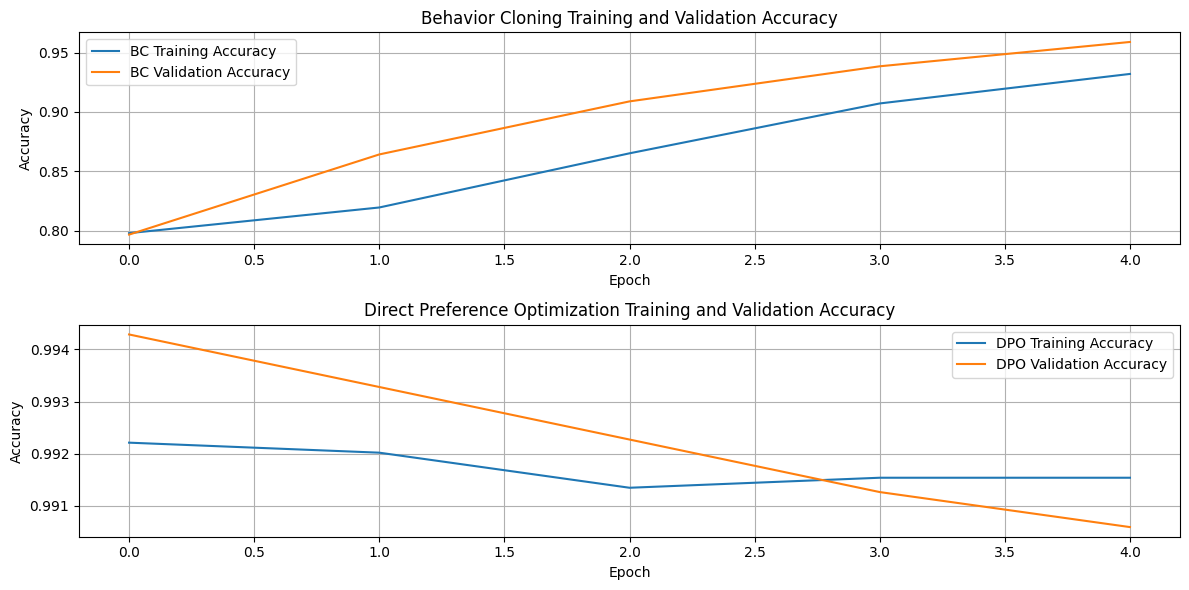

In [5]:
import matplotlib.pyplot as plt

# Assuming bc_history_df and dpo_history_df have columns 'loss', 'val_loss', 'accuracy', 'val_accuracy'
plt.figure(figsize=(12, 6))

# Plot training and validation loss for Behavior Cloning
plt.subplot(2, 1, 1)
plt.plot(bc_history_df['loss'], label='BC Training Loss')
plt.plot(bc_history_df['val_loss'], label='BC Validation Loss')
plt.title('Behavior Cloning Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot training and validation loss for DPO
plt.subplot(2, 1, 2)
plt.plot(dpo_history_df['loss'], label='DPO Training Loss')
plt.plot(dpo_history_df['val_loss'], label='DPO Validation Loss')
plt.title('Direct Preference Optimization Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)


plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 6))

# Plot training and validation accuracy for Behavior Cloning
plt.subplot(2, 1, 1)
plt.plot(bc_history_df['accuracy'], label='BC Training Accuracy')
plt.plot(bc_history_df['val_accuracy'], label='BC Validation Accuracy')
plt.title('Behavior Cloning Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)


# Plot training and validation accuracy for DPO
plt.subplot(2, 1, 2)
plt.plot(dpo_history_df['accuracy'], label='DPO Training Accuracy')
plt.plot(dpo_history_df['val_accuracy'], label='DPO Validation Accuracy')
plt.title('Direct Preference Optimization Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Behavior Cloning F1-score: 0.2545
DPO F1-score: 1.0000


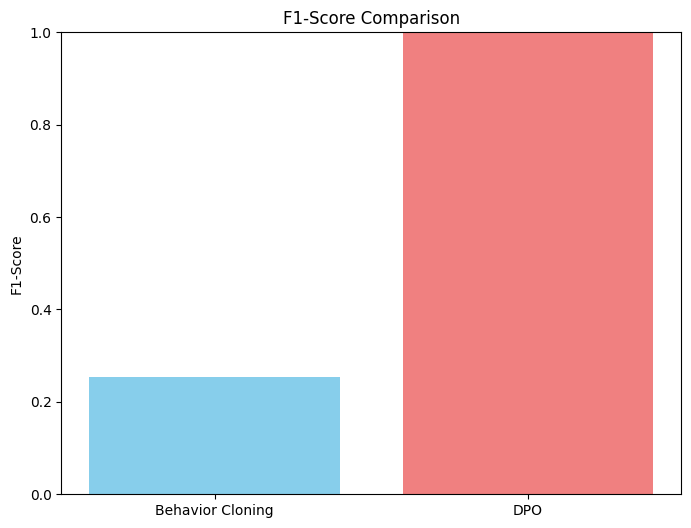

In [19]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import f1_score

def calculate_f1(model, comments_df):
    X = comments_df['body']
    Y = comments_df['toxic']
    test_data, _, _ = preprocess_dataset(X, Y, batch_size=32)

    y_pred_prob = model.predict(test_data)
    y_pred = (y_pred_prob > 0.5).astype(int)
    y_true = np.concatenate([y for x, y in test_data], axis=0)

    f1 = f1_score(y_true, y_pred)
    return f1

bc_f1 = calculate_f1(bc_model, mod_removed_comments_df)
dpo_f1 = calculate_f1(dpo_model, mod_removed_comments_df)

print(f"Behavior Cloning F1-score: {bc_f1:.4f}")
print(f"DPO F1-score: {dpo_f1:.4f}")


plt.figure(figsize=(8, 6))
plt.bar(['Behavior Cloning', 'DPO'], [bc_f1, dpo_f1], color=['skyblue', 'lightcoral'])
plt.title('F1-Score Comparison')
plt.ylabel('F1-Score')
plt.ylim(0, 1)
plt.show()